In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install torchsummary
!pip install visdom
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
import warnings
warnings.filterwarnings("ignore")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

import spectral
import numpy as np
import torch
import torch.utils
import torch.utils.data
import os
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.nn import init

# utils
import math
import os
import datetime
import numpy as np
import joblib

try:
    # Python 3
    from urllib.request import urlretrieve
except ImportError:
    # Python 2
    from urllib import urlretrieve

import warnings
warnings.filterwarnings("ignore")

In [3]:
# -*- coding: utf-8 -*-
# !pip install visdom
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import sklearn.model_selection
import seaborn as sns
import itertools
import spectral
import visdom
import matplotlib.pyplot as plt
from scipy import io, misc
import os
import re
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_device(ordinal):
    # Use GPU ?
    if ordinal < 0:
        print("Computation on CPU")
        device = torch.device('cpu')
    elif torch.cuda.is_available():
        print("Computation on CUDA GPU device {}".format(ordinal))
        device = torch.device('cuda:{}'.format(ordinal))
    else:
        print("/!\\ CUDA was requested but is not available! Computation will go on CPU. /!\\")
        device = torch.device('cpu')
    return device


def open_file(dataset):
    _, ext = os.path.splitext(dataset)
    ext = ext.lower()
    if ext == '.mat':
        # Load Matlab array
        return io.loadmat(dataset)
    elif ext == '.tif' or ext == '.tiff':
        # Load TIFF file
        return misc.imread(dataset)
    elif ext == '.hdr':
        img = spectral.open_image(dataset)
        return img.load()
    else:
        raise ValueError("Unknown file format: {}".format(ext))

def convert_to_color_(arr_2d, palette=None):
    """Convert an array of labels to RGB color-encoded image.

    Args:
        arr_2d: int 2D array of labels
        palette: dict of colors used (label number -> RGB tuple)

    Returns:
        arr_3d: int 2D images of color-encoded labels in RGB format

    """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)
    if palette is None:
        raise Exception("Unknown color palette")

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d


def convert_from_color_(arr_3d, palette=None):
    """Convert an RGB-encoded image to grayscale labels.

    Args:
        arr_3d: int 2D image of color-coded labels on 3 channels
        palette: dict of colors used (RGB tuple -> label number)

    Returns:
        arr_2d: int 2D array of labels

    """
    if palette is None:
        raise Exception("Unknown color palette")

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


def display_predictions(pred, vis=None, gt=None, caption=""):
#     if gt is None:
#         vis.images([np.transpose(pred, (2, 0, 1))],
#                     opts={'caption': caption})
#     else:
#         vis.images([np.transpose(pred, (2, 0, 1)),
#                     np.transpose(gt, (2, 0, 1))],
#                     nrow=2,
#                     opts={'caption': caption})
    pass

def display_dataset(img, gt, bands, labels, palette, vis=None):
    """Display the specified dataset.

    Args:
        img: 3D hyperspectral image
        gt: 2D array labels
        bands: tuple of RGB bands to select
        labels: list of label class names
        palette: dict of colors
        display (optional): type of display, if any

    """
    print("Image has dimensions {}x{} and {} channels".format(*img.shape))
    rgb = spectral.get_rgb(img, bands)
    rgb /= np.max(rgb)
    rgb = np.asarray(255 * rgb, dtype='uint8')

    # Display the RGB composite image
    caption = "RGB (bands {}, {}, {})".format(*bands)
#     # send to visdom server
#     vis.images([np.transpose(rgb, (2, 0, 1))],
#                 opts={'caption': caption})

def explore_spectrums(img, complete_gt, class_names, vis=None,
                      ignored_labels=None):
    """Plot sampled spectrums with mean + std for each class.

    Args:
        img: 3D hyperspectral image
        complete_gt: 2D array of labels
        class_names: list of class names
        ignored_labels (optional): list of labels to ignore
        vis : Visdom display
    Returns:
        mean_spectrums: dict of mean spectrum by class

    """
    mean_spectrums = {}
    for c in np.unique(complete_gt):
        if c in ignored_labels:
            continue
        mask = complete_gt == c
        class_spectrums = img[mask].reshape(-1, img.shape[-1])
        step = max(1, class_spectrums.shape[0] // 100)
        fig = plt.figure()
        plt.title(class_names[c])
        # Sample and plot spectrums from the selected class
        for spectrum in class_spectrums[::step, :]:
            plt.plot(spectrum, alpha=0.25)
        mean_spectrum = np.mean(class_spectrums, axis=0)
        std_spectrum = np.std(class_spectrums, axis=0)
        lower_spectrum = np.maximum(0, mean_spectrum - std_spectrum)
        higher_spectrum = mean_spectrum + std_spectrum

        # Plot the mean spectrum with thickness based on std
        plt.fill_between(range(len(mean_spectrum)), lower_spectrum,
                         higher_spectrum, color="#3F5D7D")
        plt.plot(mean_spectrum, alpha=1, color="#FFFFFF", lw=2)
#         vis.matplot(plt)
        mean_spectrums[class_names[c]] = mean_spectrum
    return mean_spectrums


def plot_spectrums(spectrums, vis=None, title=""):
    """Plot the specified dictionary of spectrums.

    Args:
        spectrums: dictionary (name -> spectrum) of spectrums to plot
        vis: Visdom display
    """
#     win = None
#     for k, v in spectrums.items():
#         n_bands = len(v)
#         update = None if win is None else 'append'
#         win = vis.line(X=np.arange(n_bands), Y=v, name=k, win=win, update=update,
#                        opts={'title': title})


def build_dataset(mat, gt, ignored_labels=None):
    """Create a list of training samples based on an image and a mask.

    Args:
        mat: 3D hyperspectral matrix to extract the spectrums from
        gt: 2D ground truth
        ignored_labels (optional): list of classes to ignore, e.g. 0 to remove
        unlabeled pixels
        return_indices (optional): bool set to True to return the indices of
        the chosen samples

    """
    samples = []
    labels = []
    # Check that image and ground truth have the same 2D dimensions
    assert mat.shape[:2] == gt.shape[:2]

    for label in np.unique(gt):
        if label in ignored_labels:
            continue
        else:
            indices = np.nonzero(gt == label)
            samples += list(mat[indices])
            labels += len(indices[0]) * [label]
    return np.asarray(samples), np.asarray(labels)


def get_random_pos(img, window_shape):
    """ Return the corners of a random window in the input image

    Args:
        img: 2D (or more) image, e.g. RGB or grayscale image
        window_shape: (width, height) tuple of the window

    Returns:
        xmin, xmax, ymin, ymax: tuple of the corners of the window

    """
    w, h = window_shape
    W, H = img.shape[:2]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2


def padding_image(image, patch_size=None, mode="symmetric", constant_values=0):
    """Padding an input image.
    Modified at 2020.11.16. If you find any issues, please email at mengxue_zhang@hhu.edu.cn with details.

    Args:
        image: 2D+ image with a shape of [h, w, ...],
        The array to pad
        patch_size: optional, a list include two integers, default is [1, 1] for pure spectra algorithm,
        The patch size of the algorithm
        mode: optional, str or function, default is "symmetric",
        Including 'constant', 'reflect', 'symmetric', more details see np.pad()
        constant_values: optional, sequence or scalar, default is 0,
        Used in 'constant'.  The values to set the padded values for each axis
    Returns:
        padded_image with a shape of [h + patch_size[0] // 2 * 2, w + patch_size[1] // 2 * 2, ...]

    """
    if patch_size is None:
        patch_size = [1, 1]
    h = patch_size[0] // 2
    w = patch_size[1] // 2
    pad_width = [[h, h], [w, w]]
    [pad_width.append([0, 0]) for i in image.shape[2:]]
    padded_image = np.pad(image, pad_width, mode=mode, constant_values=constant_values)
    return padded_image


def sliding_window(image, step=10, window_size=(20, 20), with_data=True):
    """Sliding window generator over an input image.

    Args:
        image: 2D+ image to slide the window on, e.g. RGB or hyperspectral
        step: int stride of the sliding window
        window_size: int tuple, width and height of the window
        with_data (optional): bool set to True to return both the data and the
        corner indices
    Yields:
        ([data], x, y, w, h) where x and y are the top-left corner of the
        window, (w,h) the window size

    """
    # slide a window across the image
    w, h = window_size
    W, H = image.shape[:2]
    offset_w = (W - w) % step
    offset_h = (H - h) % step
    """
    Compensate one for the stop value of range(...). because this function does not include the stop value.
    Two examples are listed as follows.
    When step = 1, supposing w = h = 3, W = H = 7, and step = 1.
    Then offset_w = 0, offset_h = 0.
    In this case, the x should have been ranged from 0 to 4 (4-6 is the last window),
    i.e., x is in range(0, 5) while W (7) - w (3) + offset_w (0) + 1 = 5. Plus one !
    Range(0, 5, 1) equals [0, 1, 2, 3, 4].

    When step = 2, supposing w = h = 3, W = H = 8, and step = 2.
    Then offset_w = 1, offset_h = 1.
    In this case, x is in [0, 2, 4] while W (8) - w (3) + offset_w (1) + 1 = 6. Plus one !
    Range(0, 6, 2) equals [0, 2, 4]/

    Same reason to H, h, offset_h, and y.
    """
    for x in range(0, W - w + offset_w + 1, step):
        if x + w > W:
            x = W - w
        for y in range(0, H - h + offset_h + 1, step):
            if y + h > H:
                y = H - h
            if with_data:
                yield image[x:x + w, y:y + h], x, y, w, h
            else:
                yield x, y, w, h


def count_sliding_window(top, step=10, window_size=(20, 20)):
    """ Count the number of windows in an image.

    Args:
        image: 2D+ image to slide the window on, e.g. RGB or hyperspectral, ...
        step: int stride of the sliding window
        window_size: int tuple, width and height of the window
    Returns:
        int number of windows
    """
    sw = sliding_window(top, step, window_size, with_data=False)
    return sum(1 for _ in sw)


def grouper(n, iterable):
    """ Browse an iterable by grouping n elements by n elements.

    Args:
        n: int, size of the groups
        iterable: the iterable to Browse
    Yields:
        chunk of n elements from the iterable

    """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk


def metrics(prediction, target, ignored_labels=[], n_classes=None):
    """Compute and print metrics (accuracy, confusion matrix and F1 scores).

    Args:
        prediction: list of predicted labels
        target: list of target labels
        ignored_labels (optional): list of labels to ignore, e.g. 0 for undef
        n_classes (optional): number of classes, max(target) by default
    Returns:
        accuracy, F1 score by class, confusion matrix
    """
    ignored_mask = np.zeros(target.shape[:2], dtype=np.bool)
    for l in ignored_labels:
        ignored_mask[target == l] = True
    ignored_mask = ~ignored_mask
    target = target[ignored_mask]
    prediction = prediction[ignored_mask]

    results = {}

    n_classes = np.max(target) + 1 if n_classes is None else n_classes

    cm = confusion_matrix(
        target,
        prediction,
        labels=range(n_classes))

    results["Confusion matrix"] = cm

    # Compute global accuracy
    total = np.sum(cm)
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)

    results["Accuracy"] = accuracy

    # Compute F1 score
    F1scores = np.zeros(len(cm))
    for i in range(len(cm)):
        try:
            F1 = 2. * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i]))
        except ZeroDivisionError:
            F1 = 0.
        F1scores[i] = F1

    results["F1 scores"] = F1scores

    # Compute kappa coefficient
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / \
        float(total * total)
    kappa = (pa - pe) / (1 - pe)
    results["Kappa"] = kappa

    return results


def show_results(results, vis=None, label_values=None, agregated=False):
    text = ""

    if agregated:
        accuracies = [r["Accuracy"] for r in results]
        kappas = [r["Kappa"] for r in results]
        F1_scores = [r["F1 scores"] for r in results]

        F1_scores_mean = np.mean(F1_scores, axis=0)
        F1_scores_std = np.std(F1_scores, axis=0)
        cm = np.mean([r["Confusion matrix"] for r in results], axis=0)
        text += "Agregated results :\n"
    else:
        cm = results["Confusion matrix"]
        accuracy = results["Accuracy"]
        F1scores = results["F1 scores"]
        kappa = results["Kappa"]

#     vis.heatmap(cm, opts={'title': "Confusion matrix",
#                           'marginbottom': 150,
#                           'marginleft': 150,
#                           'width': 500,
#                           'height': 500,
#                           'rownames': label_values, 'columnnames': label_values})
    text += "Confusion matrix :\n"
    text += str(cm)
    text += "---\n"

    if agregated:
        text += ("Accuracy: {:.03f} +- {:.03f}\n".format(np.mean(accuracies),
                                                         np.std(accuracies)))
    else:
        text += "Accuracy : {:.03f}%\n".format(accuracy)
    text += "---\n"

    text += "F1 scores :\n"
    if agregated:
        for label, score, std in zip(label_values, F1_scores_mean,
                                     F1_scores_std):
            text += "\t{}: {:.03f} +- {:.03f}\n".format(label, score, std)
    else:
        for label, score in zip(label_values, F1scores):
            text += "\t{}: {:.03f}\n".format(label, score)
    text += "---\n"

    if agregated:
        text += ("Kappa: {:.03f} +- {:.03f}\n".format(np.mean(kappas),
                                                      np.std(kappas)))
    else:
        text += "Kappa: {:.03f}\n".format(kappa)

#     vis.text(text.replace('\n', '<br/>'))
    print(text)


def sample_gt(gt, train_size, mode='fixed'):
    """Extract a fixed percentage of samples from an array of labels.

    Args:
        gt: a 2D array of int labels
        percentage: [0, 1] float
    Returns:
        train_gt, test_gt: 2D arrays of int labels

    """
    indices = np.nonzero(gt)
    X = list(zip(*indices)) # x,y features
    y = gt[indices].ravel() # classes
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_size > 1:
       train_size = int(train_size)

    if mode == 'random':
       train_indices, test_indices = sklearn.model_selection.train_test_split(X, train_size=train_size, stratify=y)
       train_indices = [list(t) for t in zip(*train_indices)]
       test_indices = [list(t) for t in zip(*test_indices)]
       train_gt[train_indices] = gt[train_indices]
       test_gt[test_indices] = gt[test_indices]
    elif mode == 'fixed':
       print("Sampling {} with train size = {}".format(mode, train_size))
       train_indices, test_indices = [], []
       for c in np.unique(gt):
           if c == 0:
              continue
           indices = np.nonzero(gt == c)
           X = list(zip(*indices)) # x,y features

           train, test = sklearn.model_selection.train_test_split(X, train_size=train_size)
           train_indices += train
           test_indices += test
       train_indices = [list(t) for t in zip(*train_indices)]
       test_indices = [list(t) for t in zip(*test_indices)]
       train_gt[train_indices] = gt[train_indices]
       test_gt[test_indices] = gt[test_indices]

    elif mode == 'disjoint':
        train_gt = np.copy(gt)
        test_gt = np.copy(gt)
        for c in np.unique(gt):
            mask = gt == c
            for x in range(gt.shape[0]):
                first_half_count = np.count_nonzero(mask[:x, :])
                second_half_count = np.count_nonzero(mask[x:, :])
                try:
                    ratio = first_half_count / (first_half_count + second_half_count)
                    if ratio > 0.9 * train_size:
                        break
                except ZeroDivisionError:
                    continue
            mask[:x, :] = 0
            train_gt[mask] = 0

        test_gt[train_gt > 0] = 0
    else:
        raise ValueError("{} sampling is not implemented yet.".format(mode))
    return train_gt, test_gt


def compute_imf_weights(ground_truth, n_classes=None, ignored_classes=[]):
    """ Compute inverse median frequency weights for class balancing.

    For each class i, it computes its frequency f_i, i.e the ratio between
    the number of pixels from class i and the total number of pixels.

    Then, it computes the median m of all frequencies. For each class the
    associated weight is m/f_i.

    Args:
        ground_truth: the annotations array
        n_classes: number of classes (optional, defaults to max(ground_truth))
        ignored_classes: id of classes to ignore (optional)
    Returns:
        numpy array with the IMF coefficients
    """
    n_classes = np.max(ground_truth) if n_classes is None else n_classes
    weights = np.zeros(n_classes)
    frequencies = np.zeros(n_classes)

    for c in range(0, n_classes):
        if c in ignored_classes:
            continue
        frequencies[c] = np.count_nonzero(ground_truth == c)

    # Normalize the pixel counts to obtain frequencies
    frequencies /= np.sum(frequencies)
    # Obtain the median on non-zero frequencies
    idx = np.nonzero(frequencies)
    median = np.median(frequencies[idx])
    weights[idx] = median / frequencies[idx]
    weights[frequencies == 0] = 0.
    return weights

def camel_to_snake(name):
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s).lower()


In [4]:
DATASETS_CONFIG = {
    "PaviaC": {
        "urls": [
            "http://www.ehu.eus/ccwintco/uploads/e/e3/Pavia.mat",
            "http://www.ehu.eus/ccwintco/uploads/5/53/Pavia_gt.mat",
        ],
        "img": "Pavia.mat",
        "gt": "Pavia_gt.mat",
    },
    "IndianPines": {
        "urls": [
            "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat",
            "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat",
        ],
        "img": "Indian_pines_corrected.mat",
        "gt": "Indian_pines_gt.mat",
    },
    "PaviaU": {
        "urls": [
            "http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat",
            "http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat",
        ],
        "img": "PaviaU.mat",
        "gt": "PaviaU_gt.mat",
    },
    "Botswana": {
        "urls": [
            "http://www.ehu.es/ccwintco/uploads/7/72/Botswana.mat",
            "http://www.ehu.es/ccwintco/uploads/5/58/Botswana_gt.mat",
        ],
        "img": "Botswana.mat",
        "gt": "Botswana_gt.mat",
    },
    
}
def get_dataset(dataset_name, target_folder="./", datasets=DATASETS_CONFIG):
    """Gets the dataset specified by name and return the related components.
    Args:
        dataset_name: string with the name of the dataset
        target_folder (optional): folder to store the datasets, defaults to ./
        datasets (optional): dataset configuration dictionary, defaults to prebuilt one
    Returns:
        img: 3D hyperspectral image (WxHxB)
        gt: 2D int array of labels
        label_values: list of class names
        ignored_labels: list of int classes to ignore
        rgb_bands: int tuple that correspond to red, green and blue bands
    """
    palette = None

    if dataset_name not in datasets.keys():
        raise ValueError("{} dataset is unknown.".format(dataset_name))

    dataset = datasets[dataset_name]

    folder = target_folder + datasets[dataset_name].get("folder", dataset_name + "/")
    if dataset.get("download", True):
        # Download the dataset if is not present
        if not os.path.isdir(folder):
            os.makedirs(folder)
        for url in datasets[dataset_name]["urls"]:
            # download the files"IndianPines"
            filename = url.split("/")[-1]
            if not os.path.exists(folder + filename):
                with TqdmUpTo(
                    unit="B",
                    unit_scale=True,
                    miniters=1,
                    desc="Downloading {}".format(filename),
                ) as t:
#                 urlretrieve(url, filename=folder + filename)
                    urlretrieve(url, filename=folder + filename, reporthook=t.update_to)
    elif not os.path.isdir(folder):
        print("WARNING: {} is not downloadable.".format(dataset_name))

    if dataset_name == "PaviaC":
        # Load the image
        img = open_file(folder + "Pavia.mat")["pavia"]

        rgb_bands = (55, 41, 12)

        gt = open_file(folder + "Pavia_gt.mat")["pavia_gt"]

        label_values = [
            "Undefined",
            "Water",
            "Trees",
            "Asphalt",
            "Self-Blocking Bricks",
            "Bitumen",
            "Tiles",
            "Shadows",
            "Meadows",
            "Bare Soil",
        ]

        ignored_labels = [0]
        
    elif dataset_name == "Botswana":
        # Load the image
        img = open_file(folder + "Botswana.mat")["Botswana"]

        rgb_bands = (75, 33, 15)

        gt = open_file(folder + "Botswana_gt.mat")["Botswana_gt"]
        label_values = [
            "Undefined",
            "Water",
            "Hippo grass",
            "Floodplain grasses 1",
            "Floodplain grasses 2",
            "Reeds",
            "Riparian",
            "Firescar",
            "Island interior",
            "Acacia woodlands",
            "Acacia shrublands",
            "Acacia grasslands",
            "Short mopane",
            "Mixed mopane",
            "Exposed soils",
        ]

        ignored_labels = [0]
    elif dataset_name == "PaviaU":
        # Load the image
        img = open_file(folder + "PaviaU.mat")["paviaU"]

        rgb_bands = (55, 41, 12)

        gt = open_file(folder + "PaviaU_gt.mat")["paviaU_gt"]

        label_values = [
            "Undefined",
            "Asphalt",
            "Meadows",
            "Gravel",
            "Trees",
            "Painted metal sheets",
            "Bare Soil",
            "Bitumen",
            "Self-Blocking Bricks",
            "Shadows",
        ]

        ignored_labels = [0]


    
    elif dataset_name == "IndianPines":
        # Load the image
        img = open_file(folder + "Indian_pines_corrected.mat")
        img = img["indian_pines_corrected"]

        rgb_bands = (43, 21, 11)  # AVIRIS sensor

        gt = open_file(folder + "Indian_pines_gt.mat")["indian_pines_gt"]
        label_values = [
            "Undefined",
            "Alfalfa",
            "Corn-notill",
            "Corn-mintill",
            "Corn",
            "Grass-pasture",
            "Grass-trees",
            "Grass-pasture-mowed",
            "Hay-windrowed",
            "Oats",
            "Soybean-notill",
            "Soybean-mintill",
            "Soybean-clean",
            "Wheat",
            "Woods",
            "Buildings-Grass-Trees-Drives",
            "Stone-Steel-Towers",
        ]

        ignored_labels = [0]

    else:
        # Custom dataset
        (
            img,
            gt,
            rgb_bands,
            ignored_labels,
            label_values,
            palette,
        ) = CUSTOM_DATASETS_CONFIG[dataset_name]["loader"](folder)

    # Filter NaN out
    nan_mask = np.isnan(img.sum(axis=-1))
    if np.count_nonzero(nan_mask) > 0:
        print(
            "Warning: NaN have been found in the data. It is preferable to remove them beforehand. Learning on NaN data is disabled."
        )
    img[nan_mask] = 0
    gt[nan_mask] = 0
    ignored_labels.append(0)

    ignored_labels = list(set(ignored_labels))
    # Normalization
    img = np.asarray(img, dtype="float32")
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img, gt, label_values, ignored_labels, rgb_bands, palette


class HyperX(torch.utils.data.Dataset):
    """ Generic class for a hyperspectral scene """

    def __init__(self, data, gt, **hyperparams):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the spatial neighbourhood
            center_pixel: bool, set to True to consider only the label of the
                          center pixel
            data_augmentation: bool, set to True to perform random flips
            supervision: 'full' or 'semi' supervised algorithms
        """
        super(HyperX, self).__init__()
        self.data = data
        self.label = gt
        self.name = hyperparams["dataset"]
        self.patch_size = hyperparams["patch_size"]
        self.ignored_labels = set(hyperparams["ignored_labels"])
        self.flip_augmentation = hyperparams["flip_augmentation"]
        self.radiation_augmentation = hyperparams["radiation_augmentation"]
        self.mixture_augmentation = hyperparams["mixture_augmentation"]
        self.center_pixel = hyperparams["center_pixel"]
        supervision = hyperparams["supervision"]
        # Fully supervised : use all pixels with label not ignored
        if supervision == "full":
            mask = np.ones_like(gt)
            for l in self.ignored_labels:
                mask[gt == l] = 0
        # Semi-supervised : use all pixels, except padding
        elif supervision == "semi":
            mask = np.ones_like(gt)
        x_pos, y_pos = np.nonzero(mask)
        p = self.patch_size // 2
        self.indices = np.array(
            [
                (x, y)
                for x, y in zip(x_pos, y_pos)
                if x > p and x < data.shape[0] - p and y > p and y < data.shape[1] - p
            ]
        )
        self.labels = [self.label[x, y] for x, y in self.indices]
        np.random.shuffle(self.indices)

    @staticmethod
    def flip(*arrays):
        horizontal = np.random.random() > 0.5
        vertical = np.random.random() > 0.5
        if horizontal:
            arrays = [np.fliplr(arr) for arr in arrays]
        if vertical:
            arrays = [np.flipud(arr) for arr in arrays]
        return arrays

    @staticmethod
    def radiation_noise(data, alpha_range=(0.9, 1.1), beta=1 / 25):
        alpha = np.random.uniform(*alpha_range)
        noise = np.random.normal(loc=0.0, scale=1.0, size=data.shape)
        return alpha * data + beta * noise

#     def mixture_noise(self, data, label, beta=1 / 25):
#         alpha1, alpha2 = np.random.uniform(0.01, 1.0, size=2)
#         noise = np.random.normal(loc=0.0, scale=1.0, size=data.shape)
#         data2 = np.zeros_like(data)
#         for idx, value in np.ndenumerate(label):
#             if value not in self.ignored_labels:
#                 l_indices = np.nonzero(self.labels == value)[0]
#                 l_indice = np.random.choice(l_indices)
#                 assert self.labels[l_indice] == value
#                 x, y = self.indices[l_indice]
#                 data2[idx] = self.data[x, y]
#         return (alpha1 * data + alpha2 * data2) / (alpha1 + alpha2) + beta * noise
    def mixture_noise(self, data, label, beta=1 / 25):
        alpha1, alpha2 = np.random.uniform(0.01, 1.0, size=2)
        noise = np.random.normal(loc=0.0, scale=1.0, size=data.shape)
        data2 = np.zeros_like(data)
        for idx, value in np.ndenumerate(label):
            if value not in self.ignored_labels:
                l_indices = np.nonzero(self.labels == value)[0]
                if len(l_indices) > 0:
                    l_indice = np.random.choice(l_indices)
                    assert self.labels[l_indice] == value
                    x, y = self.indices[l_indice]
                    data2[idx] = self.data[x, y]
        return (alpha1 * data + alpha2 * data2) / (alpha1 + alpha2) + beta * noise


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data[x1:x2, y1:y2]
        label = self.label[x1:x2, y1:y2]

        if self.flip_augmentation and self.patch_size > 1:
            # Perform data augmentation (only on 2D patches)
            data, label = self.flip(data, label)
        if self.radiation_augmentation and np.random.random() < 0.1:
            data = self.radiation_noise(data)
        if self.mixture_augmentation and np.random.random() < 0.2:
            data = self.mixture_noise(data, label)

        # Copy the data into numpy arrays (PyTorch doesn't like numpy views)
        data = np.asarray(np.copy(data).transpose((2, 0, 1)), dtype="float32")
        label = np.asarray(np.copy(label), dtype="int64")

        # Load the data into PyTorch tensors
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        # Extract the center label if needed
        if self.center_pixel and self.patch_size > 1:
            label = label[self.patch_size // 2, self.patch_size // 2]
        # Remove unused dimensions when we work with invidual spectrums
        elif self.patch_size == 1:
            data = data[:, 0, 0]
            label = label[0, 0]

        # Add a fourth dimension for 3D CNN
        if self.patch_size > 1:
            # Make 4D data ((Batch x) Planes x Channels x Width x Height)
            data = data.unsqueeze(0)
        return data, label

class TqdmUpTo(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""

    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize



In [5]:
# gt

In [6]:
# # import matplotlib.pyplot as plt
# plt.hist(gt.flatten(),bins=list(range(10)))

In [7]:
def label_noise(temp,per=0.1):
    y=temp.flatten()
    noise_percentage = per
    num_to_change = int(len(y) * noise_percentage)

    classes = np.unique(y)
    indices_to_change = np.random.choice(len(y), num_to_change, replace=False)

    # randomly assign labels to the selected indices
    for idx in indices_to_change:
        # get the current label
        current_label = y[idx]
        if current_label==0:
            continue

        # generate a new label that is different from the current label
        new_label = np.random.choice(classes[(classes != current_label) & (classes != 0)])

        # assign the new label to the selected index
        y[idx] = new_label
    return y.reshape(temp.shape)

In [8]:
# plt.hist(y.flatten(),bins=list(range(10)))

In [9]:
# plt.hist(gt.flatten(),bins=list(range(10)))

In [10]:
DATASET='PaviaU'
MODEL="(2D CNN)"
# # viz = visdom.Visdom(env=DATASET + " " + MODEL)
# if not viz.check_connection:
#     print("Visdom is not connected. Did you run 'python -m visdom.server' ?")
    
img, gt, LABEL_VALUES, IGNORED_LABELS, RGB_BANDS, palette =get_dataset(DATASET)
# Number of classes
N_CLASSES = len(LABEL_VALUES)
# Number of bands (last dimension of the image tensor)
N_BANDS = img.shape[-1]

if palette is None:
    # Generate color palette
    palette = {0: (0, 0, 0)}
    for k, color in enumerate(sns.color_palette("hls", len(LABEL_VALUES) - 1)):
        palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype="uint8"))
invert_palette = {v: k for k, v in palette.items()}


def convert_to_color(x):
    return convert_to_color_(x, palette=palette)


def convert_from_color(x):
    return convert_from_color_(x, palette=invert_palette)
display_dataset(img, gt, RGB_BANDS, LABEL_VALUES, palette)
color_gt = convert_to_color(gt)

Image has dimensions 610x340 and 103 channels


In [11]:
# gt.shape

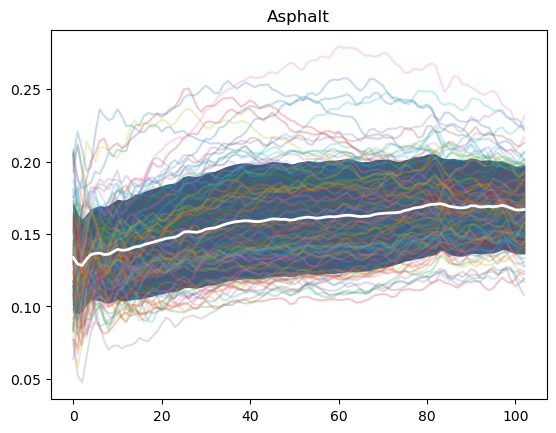

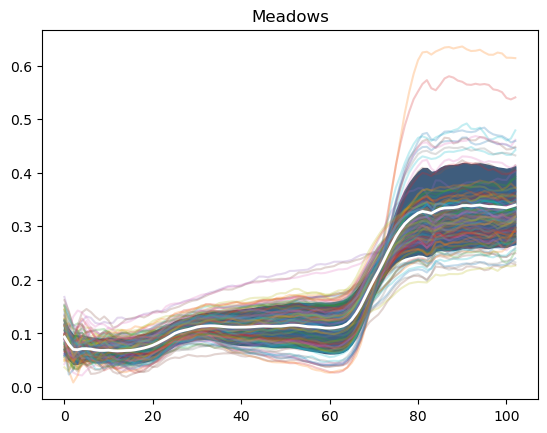

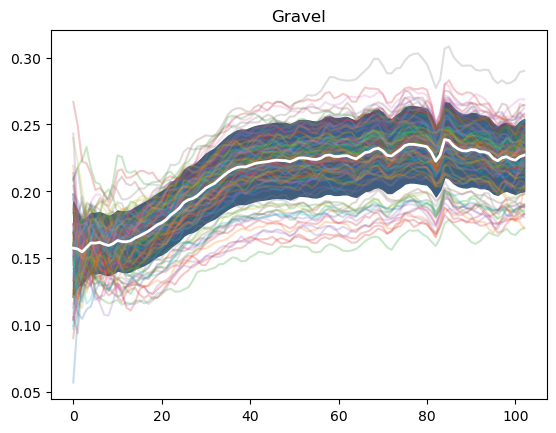

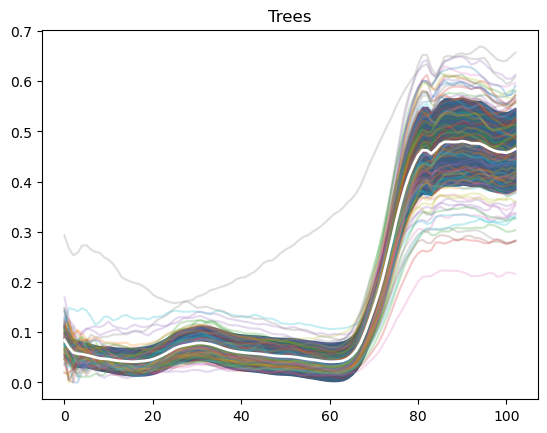

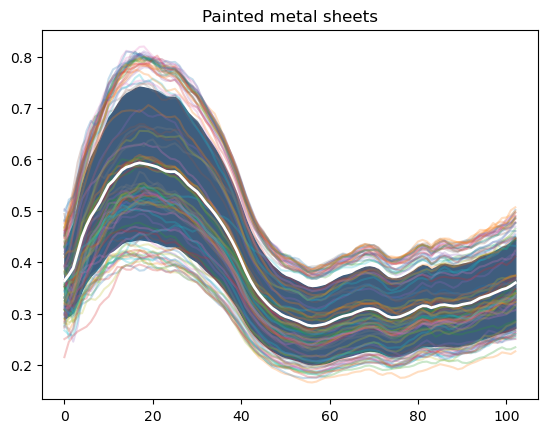

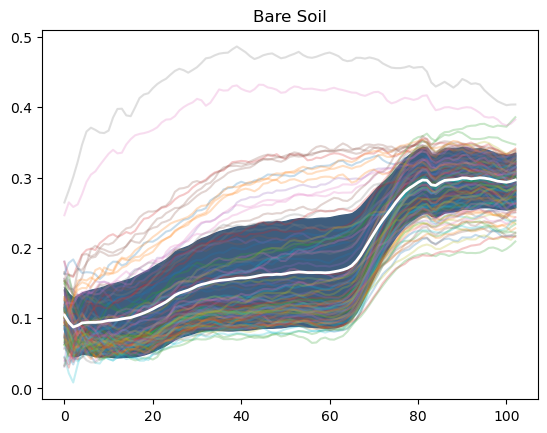

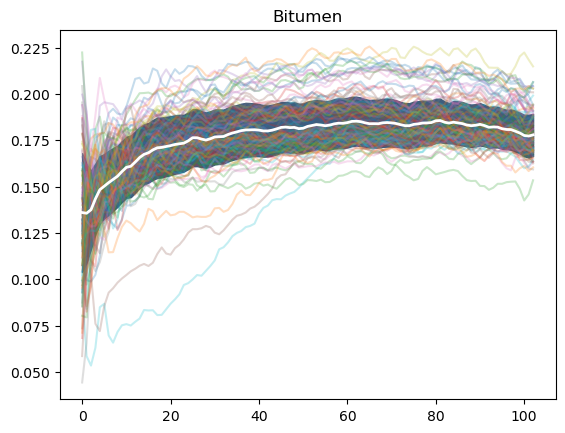

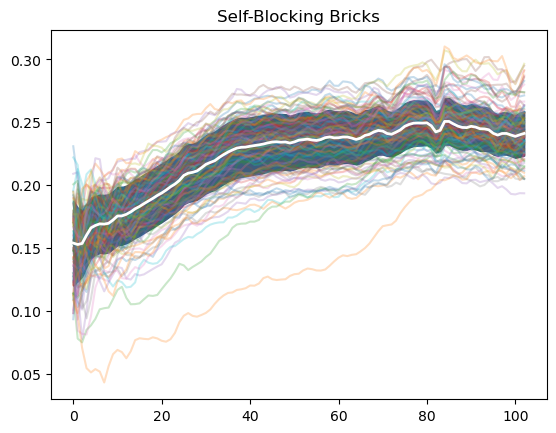

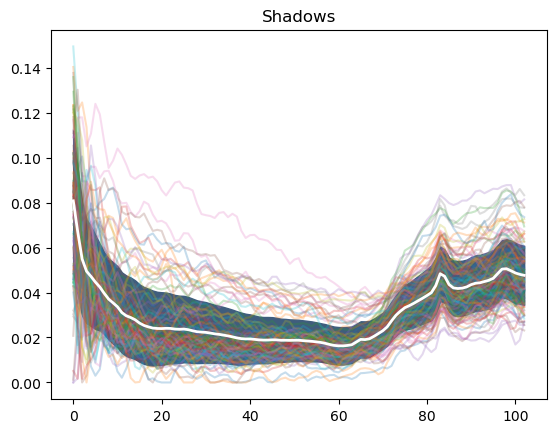

In [12]:
if 1 or DATAVIZ:
    # Data exploration : compute and show the mean spectrums
    mean_spectrums = explore_spectrums(
        img, gt, LABEL_VALUES, ignored_labels=IGNORED_LABELS
    )
    plot_spectrums(mean_spectrums, title="Mean spectrum/class")

In [13]:
import torch.nn as nn

class SharmaEtAl(nn.Module):
    """
    HYPERSPECTRAL CNN FOR IMAGE CLASSIFICATION & BAND SELECTION, WITH APPLICATION
    TO FACE RECOGNITION
    Vivek Sharma, Ali Diba, Tinne Tuytelaars, Luc Van Gool
    Technical Report, KU Leuven/ETH Zürich
    """

    @staticmethod
    def weight_init(m):
        if isinstance(m, (nn.Linear, nn.Conv3d)):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes, patch_size=64):
        super(SharmaEtAl, self).__init__()
        self.input_channels = input_channels
        self.patch_size = patch_size

        # An input image of size 263x263 pixels is fed to conv1
        # with 96 kernels of size 6x6x96 with a stride of 2 pixels
        self.conv1 = nn.Conv3d(1, 96, (input_channels, 6, 6), stride=(1, 2, 2))
        self.conv1_bn = nn.BatchNorm3d(96)
        self.conv1.weight=torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool1 = nn.MaxPool3d((1, 2, 2))
        
        #  256 kernels of size 3x3x256 with a stride of 2 pixels
        self.conv2 = nn.Conv3d(1, 256, (96, 3, 3), stride=(1, 2, 2))
        self.conv2_bn = nn.BatchNorm3d(256)
        self.conv2.weight=torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.pool2 = nn.MaxPool3d((1, 2, 2))
        
        # 512 kernels of size 3x3x512 with a stride of 1 pixel
        self.conv3 = nn.Conv3d(1, 512, (256, 3, 3), stride=(1, 1, 1))
        self.conv3.weight=torch.nn.init.kaiming_uniform_(self.conv3.weight)
        
        # Considering those large kernel values, I assume they actually merge the
        # 3D tensors at each step

        self.features_size = self._get_final_flattened_size()

        # The fc1 has 1024 outputs, where dropout was applied after
        # fc1 with a rate of 0.5
        self.fc1 = nn.Linear(self.features_size, 1024)
        self.fc1.weight=torch.nn.init.kaiming_uniform_(self.fc1.weight)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(1024, n_classes)
        self.fc2.weight=torch.nn.init.kaiming_uniform_(self.fc2.weight)

        #self.apply(self.weight_init)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(
                (1, 1, self.input_channels, self.patch_size, self.patch_size)
            )
            x = F.relu(self.conv1_bn(self.conv1(x)))
            x = self.pool1(x)
#             print(x.size())
            b, t, c, w, h = x.size()
            x = x.view(b, 1, t * c, w, h)
            x = F.relu(self.conv2_bn(self.conv2(x)))
            x = self.pool2(x)
#             print(x.size())
            b, t, c, w, h = x.size()
            x = x.view(b, 1, t * c, w, h)
            x = F.relu(self.conv3(x))
#             print(x.size())
            _, t, c, w, h = x.size()
        return t * c * w * h

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.pool1(x)
        b, t, c, w, h = x.size()
        x = x.view(b, 1, t * c, w, h)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool2(x)
        b, t, c, w, h = x.size()
        x = x.view(b, 1, t * c, w, h)
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.features_size)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
def get_model(name = "sharma", **kwargs):
    """
    Instantiate and obtain a model with adequate hyperparameters

    Args:
        name: string of the model name
        kwargs: hyperparameters
    Returns:
        model: PyTorch network
        optimizer: PyTorch optimizer
        criterion: PyTorch loss Function
        kwargs: hyperparameters with sane defaults
    """
    device = kwargs["device"]
    n_classes = kwargs["n_classes"]
    n_bands = kwargs["n_bands"]
    weights = torch.ones(n_classes)
    weights[torch.LongTensor(kwargs["ignored_labels"])] = 0.0
    weights = weights.to(kwargs["device"])
    weights = kwargs.setdefault("weights", weights)

    
    if 1 or name == "sharma":
        # We train our S-CNN from scratch using stochastic gradient descent with
        # momentum set to 0.9, weight decay of 0.0005, and with a batch size
        # of 60.  We initialize an equal learning rate for all trainable layers
        # to 0.05, which is manually decreased by a factor of 10 when the validation
        # error stopped decreasing. Prior to the termination the learning rate was
        # reduced two times at 15th and 25th epoch. [...]
        # We trained the network for 30 epochs
        kwargs.setdefault("batch_size", 60)
        epoch = kwargs.setdefault("epoch", 40)
        lr = kwargs.setdefault("lr", 0.05)
        center_pixel = True
        # We assume patch_size = 64
        kwargs.setdefault("patch_size", 64)
        
        model = SharmaEtAl(n_bands, n_classes, patch_size=kwargs["patch_size"])
#         print(model)
        
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.0005)
        criterion = nn.CrossEntropyLoss(weight=kwargs["weights"])
        kwargs.setdefault(
            "scheduler",
            optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[epoch // 2, (5 * epoch) // 6], gamma=0.1
            ),
        )
    
    model = model.to(device)
    epoch = kwargs.setdefault("epoch", 100)
    kwargs.setdefault(
        "scheduler",
        optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=0.1, patience=epoch // 4, verbose=True
        ),
    )
    # kwargs.setdefault('scheduler', None)
    kwargs.setdefault("batch_size", 100)
    kwargs.setdefault("supervision", "full")
    kwargs.setdefault("flip_augmentation", False)
    kwargs.setdefault("radiation_augmentation", False)
    kwargs.setdefault("mixture_augmentation", False)
    kwargs["center_pixel"] = center_pixel
    return model, optimizer, criterion, kwargs


In [15]:
results = []
N_RUNS=1
TRAIN_GT=None
TEST_GT=None
SAMPLE_PERCENTAGE=0.8
SAMPLING_MODE="random"
CLASS_BALANCING=True
hyperparams={"batch_size":64,
            "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
            "epoch":20,
            "dataset":DATASET,
             "patch_size":64,
             "flip_augmentation":True,
             "radiation_augmentation":True,
             "mixture_augmentation":True,
             "center_pixel":False,
             "supervision":'full',
             'test_stride':1
            }
hyperparams.update(
    {
        "n_classes": N_CLASSES,
        "n_bands": N_BANDS,
        "ignored_labels": IGNORED_LABELS,
#         "device": CUDA_DEVICE,
    }
)
hyperparams = dict((k, v) for k, v in hyperparams.items() if v is not None)


In [16]:

def train(
    net,
    optimizer,
    criterion,
    data_loader,
    epoch,
    scheduler=None,
    display_iter=100,
    device=device,
    display=None,
    val_loader=None,
    supervision="full",
):
    """
    Training loop to optimize a network for several epochs and a specified loss

    Args:
        net: a PyTorch model
        optimizer: a PyTorch optimizer
        data_loader: a PyTorch dataset loader
        epoch: int specifying the number of training epochs
        criterion: a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
        device (optional): torch device to use (defaults to CPU)
        display_iter (optional): number of iterations before refreshing the
        display (False/None to switch off).
        scheduler (optional): PyTorch scheduler
        val_loader (optional): validation dataset
        supervision (optional): 'full' or 'semi'
    """

    if criterion is None:
        raise Exception("Missing criterion. You must specify a loss function.")

    net.to(device)

    save_epoch = epoch // 20 if epoch > 20 else 1

    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    iter_ = 1
    loss_win, val_win = None, None
    val_accuracies = []

    for e in tqdm(range(1, epoch + 1), desc="Training the network"):
        # Set the network to training mode
        net.train()
        avg_loss = 0.0

        # Run the training loop for one epoch
        for batch_idx, (data, target) in tqdm(
            enumerate(data_loader), total=len(data_loader)
        ):
            # Load the data into the GPU if required
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            if supervision == "full":
                output = net(data)
#                 target=target.type(torch.float32)
#                 target=target.float()
#                 print(output.dtype,target.dtype)
                
                loss = criterion(output.double(), target)
            elif supervision == "semi":
                outs = net(data)
                output, rec = outs
                loss = criterion[0](output, target) + net.aux_loss_weight * criterion[
                    1
                ](rec, data)
            else:
                raise ValueError(
                    'supervision mode "{}" is unknown.'.format(supervision)
                )
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0, iter_ - 100) : iter_ + 1])

            if display_iter and iter_ % display_iter == 0:
                string = "Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t{}"
                string = string.format(
                    e,
                    epoch,
                    batch_idx * len(data),
                    len(data) * len(data_loader),
                    100.0 * batch_idx / len(data_loader),
                    mean_losses[iter_],
                    losses,
                )
                update = None if loss_win is None else "append"
#                 loss_win = display.line(
#                     X=np.arange(iter_ - display_iter, iter_),
#                     Y=mean_losses[iter_ - display_iter : iter_],
#                     win=loss_win,
#                     update=update,
#                     opts={
#                         "title": "Training loss",
#                         "xlabel": "Iterations",
#                         "ylabel": "Loss",
#                     },
#                 )
                tqdm.write(string)

#                 if len(val_accuracies) > 0:
#                     val_win = display.line(
#                         Y=np.array(val_accuracies),
#                         X=np.arange(len(val_accuracies)),
#                         win=val_win,
#                         opts={
#                             "title": "Validation accuracy",
#                             "xlabel": "Epochs",
#                             "ylabel": "Accuracy",
#                         },
#                     )
            iter_ += 1
            del (data, target, loss, output)

        # Update the scheduler
        avg_loss /= len(data_loader)
        if val_loader is not None:
            val_acc = val(net, val_loader, device=device, supervision=supervision)
            val_accuracies.append(val_acc)
            metric = -val_acc
        else:
            metric = avg_loss

        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(metric)
        elif scheduler is not None:
            scheduler.step()

        # Save the weights
        if e % save_epoch == 0:
            save_model(
                net,
                camel_to_snake(str(net.__class__.__name__)),
                data_loader.dataset.name,
                epoch=e,
                metric=abs(metric),
            )


def save_model(model, model_name, dataset_name, **kwargs):
    model_dir = "./checkpoints/" + model_name + "/" + dataset_name + "/"
    """
    Using strftime in case it triggers exceptions on windows 10 system
    """
    time_str = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir, exist_ok=True)
    if isinstance(model, torch.nn.Module):
        filename = time_str + "_epoch{epoch}_{metric:.2f}".format(
            **kwargs
        )
        tqdm.write("Saving neural network weights in {}".format(filename))
        torch.save(model.state_dict(), model_dir + filename + ".pth")
    else:
        filename = time_str
        tqdm.write("Saving model params in {}".format(filename))
        joblib.dump(model, model_dir + filename + ".pkl")


def test(net, img, hyperparams):
    """
    Test a model on a specific image
    """
    net.eval()
    patch_size = hyperparams["patch_size"]
    center_pixel = hyperparams["center_pixel"]
    batch_size, device = hyperparams["batch_size"], hyperparams["device"]
    n_classes = hyperparams["n_classes"]

    kwargs = {
        "step": hyperparams["test_stride"],
        "window_size": (patch_size, patch_size),
    }
    probs = np.zeros(img.shape[:2] + (n_classes,))

    iterations = count_sliding_window(img, **kwargs) // batch_size
    for batch in tqdm(
        grouper(batch_size, sliding_window(img, **kwargs)),
        total=(iterations),
        desc="Inference on the image",
    ):
        with torch.no_grad():
            if patch_size == 1:
                data = [b[0][0, 0] for b in batch]
                data = np.copy(data)
                data = torch.from_numpy(data)
            else:
                data = [b[0] for b in batch]
                data = np.copy(data)
                data = data.transpose(0, 3, 1, 2)
                data = torch.from_numpy(data)
                data = data.unsqueeze(1)

            indices = [b[1:] for b in batch]
            data = data.to(device)
            output = net(data)
            if isinstance(output, tuple):
                output = output[0]
            output = output.to("cpu")

            if patch_size == 1 or center_pixel:
                output = output.numpy()
            else:
                output = np.transpose(output.numpy(), (0, 2, 3, 1))
            for (x, y, w, h), out in zip(indices, output):
                if center_pixel:
                    probs[x + w // 2, y + h // 2] += out
                else:
                    probs[x : x + w, y : y + h] += out
    return probs


def val(net, data_loader, device="cpu", supervision="full"):
    # TODO : fix me using metrics()
    accuracy, total = 0.0, 0.0001
    ignored_labels = data_loader.dataset.ignored_labels
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            # Load the data into the GPU if required
            data, target = data.to(device), target.to(device)
            if supervision == "full":
                output = net(data)
            elif supervision == "semi":
                outs = net(data)
                output, rec = outs
            _, output = torch.max(output, dim=1)
            for out, pred in zip(output.view(-1), target.view(-1)):
                if out.item() in ignored_labels:
                    continue
                else:
                    accuracy += out.item() == pred.item()
                    total += 1
    return accuracy / total


In [17]:
import torch.utils.data as data
from torchsummary import summary
# run the experiment several times
for run in range(N_RUNS):
    if TRAIN_GT is not None and TEST_GT is not None:
        train_gt = open_file(TRAIN_GT)
        test_gt = open_file(TEST_GT)
    elif TRAIN_GT is not None:
        train_gt = open_file(TRAIN_GT)
        test_gt = np.copy(gt)
        w, h = test_gt.shape
        test_gt[(train_gt > 0)[:w, :h]] = 0
    elif TEST_GT is not None:
        test_gt = open_file(TEST_GT)
    else:
        # Sample random training spectra
        print(gt)
#         input()
        train_gt, test_gt = sample_gt(gt, SAMPLE_PERCENTAGE, mode=SAMPLING_MODE)
        train_gt=label_noise(train_gt,0.1)
    print(
        "{} samples selected (over {})".format(
            np.count_nonzero(train_gt), np.count_nonzero(gt)
        )
    )
    print(
        "Running an experiment with the {} model".format(MODEL),
        "run {}/{}".format(run + 1, N_RUNS),
    )

    display_predictions(convert_to_color(train_gt), caption="Train ground truth")
    display_predictions(convert_to_color(test_gt), caption="Test ground truth")
    
    #####################################################################################
    if 1 or CLASS_BALANCING:
            weights = compute_imf_weights(train_gt, N_CLASSES, IGNORED_LABELS)
            hyperparams["weights"] = torch.from_numpy(weights)
        # Neural network
    model, optimizer, loss, hyperparams = get_model(MODEL, **hyperparams)
    
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc2.parameters():
        param.requires_grad = True
        
    #print(model.summary())
    # Split train set in train/val
    train_gt, val_gt = sample_gt(train_gt, 0.8)
    # Generate the dataset
    train_dataset = HyperX(img, train_gt, **hyperparams)
    train_loader = data.DataLoader(
        train_dataset,
        batch_size=hyperparams["batch_size"],
        # pin_memory=hyperparams['device'],
        shuffle=True,
    )
    val_dataset = HyperX(img, val_gt, **hyperparams)
    val_loader = data.DataLoader(
        val_dataset,
        # pin_memory=hyperparams['device'],
        batch_size=hyperparams["batch_size"],
    )

#     print(hyperparams)
    print("Network :")
    with torch.no_grad():
        for input, _ in train_loader:
            break
        summary(model.to(hyperparams["device"]), input.size()[1:])
        # We would like to use device=hyperparams['device'] altough we have
        # to wait for torchsummary to be fixed first.

#     if CHECKPOINT is not None:
#         model.load_state_dict(torch.load(CHECKPOINT))

    try:
        train(
            model,
            optimizer,
            loss,
            train_loader,
            hyperparams["epoch"],
#             scheduler=hyperparams["scheduler"],
            device=hyperparams["device"],
#             supervision=hyperparams["supervision"],
            val_loader=val_loader,
            
        )
    except KeyboardInterrupt:
        # Allow the user to stop the training
        pass

    probabilities = test(model, img, hyperparams)
    prediction = np.argmax(probabilities, axis=-1)
       #################################################################################### 
        
        
    run_results = metrics(
    prediction,
    test_gt,
    ignored_labels=hyperparams["ignored_labels"],
    n_classes=N_CLASSES,
    )

    mask = np.zeros(gt.shape, dtype="bool")
    for l in IGNORED_LABELS:
        mask[gt == l] = True
    prediction[mask] = 0

    color_prediction = convert_to_color(prediction)
    display_predictions(
        color_prediction,
        
        gt=convert_to_color(test_gt),
        caption="Prediction vs. test ground truth",
    )

    results.append(run_results)
    show_results(run_results,  label_values=LABEL_VALUES)

if N_RUNS > 1:
    show_results(results,  label_values=LABEL_VALUES, agregated=True)

        

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]
34220 samples selected (over 42776)
Running an experiment with the (2D CNN) model run 1/1
Sampling fixed with train size = 0.8
Network :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 96, 1, 30, 30]         356,064
       BatchNorm3d-2        [-1, 96, 1, 30, 30]             192
         MaxPool3d-3        [-1, 96, 1, 15, 15]               0
            Conv3d-4         [-1, 256, 1, 7, 7]         221,440
       BatchNorm3d-5         [-1, 256, 1, 7, 7]             512
         MaxPool3d-6         [-1, 256, 1, 3, 3]               0
            Conv3d-7         [-1, 512, 1, 1, 1]       1,180,160
            Linear-8                 [-1, 1024]         525,312
           Dropout-9                 [-1, 1024]               0
           Linear-10                  

 32%|█████████████▎                            | 95/299 [07:39<16:54,  4.98s/it]


 33%|█████████████▊                            | 98/299 [07:54<16:23,  4.90s/it]
                                                                                
 33%|█████████████▋                           | 100/299 [08:01<14:02,  4.23s/it]

Train (epoch 1/20) [6336/19136 (33%)]	Loss: 22.965160	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 66%|███████████████████████████              | 197/299 [15:50<07:34,  4.45s/it]


 66%|███████████████████████████▏             | 198/299 [15:55<07:47,  4.63s/it]
                                                                                
 67%|███████████████████████████▍             | 200/299 [16:03<07:12,  4.37s/it]

Train (epoch 1/20) [12736/19136 (67%)]	Loss: 14.545377	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 99%|████████████████████████████████████████▋| 297/299 [24:04<00:10,  5.06s/it]


Training the network:   5%|▉                 | 1/20 [24:56<7:53:54, 1496.56s/it]

Saving neural network weights in 2023_04_05_23_32_52_epoch1_0.07



                                                                                
  0%|▏                                          | 1/299 [00:02<14:33,  2.93s/it]

Train (epoch 2/20) [0/19136 (0%)]	Loss: 14.266916	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 33%|█████████████▊                            | 98/299 [08:10<13:01,  3.89s/it]


 33%|█████████████▉                            | 99/299 [08:18<16:30,  4.95s/it]
                                                                                
 34%|█████████████▊                           | 101/299 [08:28<17:18,  5.24s/it]

Train (epoch 2/20) [6400/19136 (33%)]	Loss: 12.508577	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 66%|███████████████████████████▏             | 198/299 [16:52<08:20,  4.95s/it]


 67%|███████████████████████████▎             | 199/299 [16:59<09:13,  5.54s/it]
                                                                                
 67%|███████████████████████████▌             | 201/299 [17:13<10:17,  6.30s/it]

Train (epoch 2/20) [12800/19136 (67%)]	Loss: 12.388880	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



100%|████████████████████████████████████████▊| 298/299 [25:07<00:05,  5.70s/it]


Training the network:  10%|█▊                | 2/20 [50:50<7:39:06, 1530.36s/it]

Saving neural network weights in 2023_04_05_23_58_46_epoch2_0.06



  0%|                                                   | 0/299 [00:00<?, ?it/s]
                                                                                
  1%|▎                                          | 2/299 [00:10<25:23,  5.13s/it]

Train (epoch 3/20) [64/19136 (0%)]	Loss: 11.022780	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 33%|█████████████▉                            | 99/299 [08:02<17:28,  5.24s/it]


 33%|█████████████▋                           | 100/299 [08:07<17:22,  5.24s/it]
                                                                                
 34%|█████████████▉                           | 102/299 [08:16<16:21,  4.98s/it]

Train (epoch 3/20) [6464/19136 (34%)]	Loss: 11.542752	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 67%|███████████████████████████▎             | 199/299 [16:14<07:38,  4.58s/it]


 67%|███████████████████████████▍             | 200/299 [16:21<08:50,  5.36s/it]
                                                                                
 68%|███████████████████████████▋             | 202/299 [16:29<07:23,  4.57s/it]

Train (epoch 3/20) [12864/19136 (67%)]	Loss: 11.233158	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



100%|█████████████████████████████████████████| 299/299 [24:32<00:00,  4.92s/it]


Training the network:  15%|██▍             | 3/20 [1:16:07<7:11:50, 1524.17s/it]

Saving neural network weights in 2023_04_06_00_24_03_epoch3_0.13



  0%|▏                                          | 1/299 [00:02<14:12,  2.86s/it]
                                                                                
  1%|▍                                          | 3/299 [00:12<21:54,  4.44s/it]

Train (epoch 4/20) [128/19136 (1%)]	Loss: 11.230781	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 33%|█████████████▋                           | 100/299 [08:09<13:27,  4.06s/it]


 34%|█████████████▊                           | 101/299 [08:12<13:02,  3.95s/it]
                                                                                
 34%|██████████████                           | 103/299 [08:19<11:10,  3.42s/it]

Train (epoch 4/20) [6528/19136 (34%)]	Loss: 12.139408	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 67%|███████████████████████████▍             | 200/299 [16:01<08:43,  5.29s/it]


 67%|███████████████████████████▌             | 201/299 [16:07<09:16,  5.67s/it]
                                                                                
 68%|███████████████████████████▊             | 203/299 [16:17<08:27,  5.29s/it]

Train (epoch 4/20) [12928/19136 (68%)]	Loss: 10.500900	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  20%|███▏            | 4/20 [1:40:51<6:42:14, 1508.41s/it]

Saving neural network weights in 2023_04_06_00_48_47_epoch4_0.17



  1%|▎                                          | 2/299 [00:07<19:04,  3.85s/it]
                                                                                
  1%|▌                                          | 4/299 [00:16<20:46,  4.23s/it]

Train (epoch 5/20) [192/19136 (1%)]	Loss: 10.750436	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 34%|█████████████▊                           | 101/299 [08:21<19:30,  5.91s/it]


 34%|█████████████▉                           | 102/299 [08:28<19:49,  6.04s/it]
                                                                                
 35%|██████████████▎                          | 104/299 [08:36<16:37,  5.12s/it]

Train (epoch 5/20) [6592/19136 (34%)]	Loss: 13.008565	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 67%|███████████████████████████▌             | 201/299 [16:40<07:35,  4.65s/it]


 68%|███████████████████████████▋             | 202/299 [16:46<08:15,  5.10s/it]
                                                                                
 68%|███████████████████████████▉             | 204/299 [16:56<07:48,  4.93s/it]

Train (epoch 5/20) [12992/19136 (68%)]	Loss: 11.182716	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  25%|████            | 5/20 [2:06:01<6:17:16, 1509.10s/it]

Saving neural network weights in 2023_04_06_01_13_57_epoch5_0.10



  1%|▍                                          | 3/299 [00:15<28:36,  5.80s/it]
                                                                                
  2%|▋                                          | 5/299 [00:25<25:12,  5.14s/it]

Train (epoch 6/20) [256/19136 (1%)]	Loss: 11.159268	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 34%|█████████████▉                           | 102/299 [08:27<15:38,  4.76s/it]


 34%|██████████████                           | 103/299 [08:33<15:57,  4.89s/it]
                                                                                
 35%|██████████████▍                          | 105/299 [08:44<16:27,  5.09s/it]

Train (epoch 6/20) [6656/19136 (35%)]	Loss: 11.828564	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 68%|███████████████████████████▋             | 202/299 [16:31<08:40,  5.36s/it]


 68%|███████████████████████████▊             | 203/299 [16:34<07:18,  4.57s/it]
                                                                                
 69%|████████████████████████████             | 205/299 [16:43<07:04,  4.52s/it]

Train (epoch 6/20) [13056/19136 (68%)]	Loss: 11.850713	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  30%|████▊           | 6/20 [2:30:59<5:51:10, 1505.03s/it]

Saving neural network weights in 2023_04_06_01_38_55_epoch6_0.16



  1%|▌                                          | 4/299 [00:19<24:35,  5.00s/it]
                                                                                
  2%|▊                                          | 6/299 [00:28<22:19,  4.57s/it]

Train (epoch 7/20) [320/19136 (2%)]	Loss: 11.736125	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 34%|██████████████                           | 103/299 [08:55<19:49,  6.07s/it]


 35%|██████████████▎                          | 104/299 [08:59<17:35,  5.41s/it]
                                                                                
 35%|██████████████▌                          | 106/299 [09:07<15:44,  4.89s/it]

Train (epoch 7/20) [6720/19136 (35%)]	Loss: 11.515084	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 68%|███████████████████████████▊             | 203/299 [16:46<08:37,  5.39s/it]


 68%|███████████████████████████▉             | 204/299 [16:53<09:19,  5.89s/it]
                                                                                
 69%|████████████████████████████▏            | 206/299 [17:03<08:25,  5.43s/it]

Train (epoch 7/20) [13120/19136 (69%)]	Loss: 10.202199	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  35%|█████▌          | 7/20 [2:56:32<5:28:04, 1514.19s/it]

Saving neural network weights in 2023_04_06_02_04_28_epoch7_0.11



  2%|▋                                          | 5/299 [00:26<27:38,  5.64s/it]
                                                                                
  2%|█                                          | 7/299 [00:42<34:49,  7.16s/it]

Train (epoch 8/20) [384/19136 (2%)]	Loss: 11.448143	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 35%|██████████████▎                          | 104/299 [08:39<13:29,  4.15s/it]


 35%|██████████████▍                          | 105/299 [08:42<12:50,  3.97s/it]
                                                                                
 36%|██████████████▋                          | 107/299 [08:52<14:45,  4.61s/it]

Train (epoch 8/20) [6784/19136 (35%)]	Loss: 10.853791	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 68%|███████████████████████████▉             | 204/299 [16:46<08:18,  5.25s/it]


 69%|████████████████████████████             | 205/299 [16:49<07:24,  4.73s/it]
                                                                                
 69%|████████████████████████████▍            | 207/299 [16:59<07:13,  4.71s/it]

Train (epoch 8/20) [13184/19136 (69%)]	Loss: 10.322584	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  40%|██████▍         | 8/20 [3:21:32<5:01:57, 1509.77s/it]

Saving neural network weights in 2023_04_06_02_29_28_epoch8_0.12



  2%|▊                                          | 6/299 [00:33<26:26,  5.41s/it]
                                                                                
  3%|█▏                                         | 8/299 [00:48<32:25,  6.69s/it]

Train (epoch 9/20) [448/19136 (2%)]	Loss: 11.661302	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 35%|██████████████▍                          | 105/299 [08:51<14:41,  4.54s/it]


 35%|██████████████▌                          | 106/299 [08:56<14:50,  4.62s/it]
                                                                                
 36%|██████████████▊                          | 108/299 [09:07<16:31,  5.19s/it]

Train (epoch 9/20) [6848/19136 (36%)]	Loss: 11.419315	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 69%|████████████████████████████             | 205/299 [16:49<07:21,  4.69s/it]


 69%|████████████████████████████▏            | 206/299 [16:55<07:56,  5.12s/it]
                                                                                
 70%|████████████████████████████▌            | 208/299 [17:04<07:21,  4.85s/it]

Train (epoch 9/20) [13248/19136 (69%)]	Loss: 11.554968	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  45%|███████▏        | 9/20 [3:46:44<4:36:53, 1510.34s/it]

Saving neural network weights in 2023_04_06_02_54_40_epoch9_0.10



  2%|█                                          | 7/299 [00:33<21:35,  4.44s/it]
                                                                                
  3%|█▎                                         | 9/299 [00:47<28:07,  5.82s/it]

Train (epoch 10/20) [512/19136 (3%)]	Loss: 11.201890	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 35%|██████████████▌                          | 106/299 [08:50<16:12,  5.04s/it]


 36%|██████████████▋                          | 107/299 [08:54<15:23,  4.81s/it]
                                                                                
 36%|██████████████▉                          | 109/299 [09:02<14:40,  4.63s/it]

Train (epoch 10/20) [6912/19136 (36%)]	Loss: 11.196994	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 69%|████████████████████████████▏            | 206/299 [16:47<07:20,  4.74s/it]


 69%|████████████████████████████▍            | 207/299 [16:49<06:01,  3.93s/it]
                                                                                
 70%|████████████████████████████▋            | 209/299 [16:56<05:32,  3.69s/it]

Train (epoch 10/20) [13312/19136 (70%)]	Loss: 10.429462	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  50%|███████▌       | 10/20 [4:11:44<4:11:13, 1507.37s/it]

Saving neural network weights in 2023_04_06_03_19_40_epoch10_0.18



  3%|█▏                                         | 8/299 [00:39<25:30,  5.26s/it]
                                                                                
  3%|█▍                                        | 10/299 [00:46<21:45,  4.52s/it]

Train (epoch 11/20) [576/19136 (3%)]	Loss: 10.787614	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 36%|██████████████▋                          | 107/299 [08:33<13:57,  4.36s/it]


 36%|██████████████▊                          | 108/299 [08:35<11:36,  3.65s/it]
                                                                                
 37%|███████████████                          | 110/299 [08:47<14:37,  4.64s/it]

Train (epoch 11/20) [6976/19136 (36%)]	Loss: 11.180904	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 69%|████████████████████████████▍            | 207/299 [16:49<08:24,  5.49s/it]


 70%|████████████████████████████▌            | 208/299 [16:54<08:00,  5.28s/it]
                                                                                
 70%|████████████████████████████▊            | 210/299 [17:02<06:48,  4.59s/it]

Train (epoch 11/20) [13376/19136 (70%)]	Loss: 12.092576	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  55%|████████▎      | 11/20 [4:37:02<3:46:35, 1510.58s/it]

Saving neural network weights in 2023_04_06_03_44_58_epoch11_0.18



  3%|█▎                                         | 9/299 [00:45<26:26,  5.47s/it]
                                                                                
  4%|█▌                                        | 11/299 [00:56<26:20,  5.49s/it]

Train (epoch 12/20) [640/19136 (3%)]	Loss: 11.276589	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 36%|██████████████▊                          | 108/299 [09:00<16:09,  5.08s/it]


 36%|██████████████▉                          | 109/299 [09:08<18:52,  5.96s/it]
                                                                                
 37%|███████████████▏                         | 111/299 [09:19<17:41,  5.65s/it]

Train (epoch 12/20) [7040/19136 (37%)]	Loss: 11.189531	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 70%|████████████████████████████▌            | 208/299 [17:29<07:44,  5.10s/it]


 70%|████████████████████████████▋            | 209/299 [17:33<07:14,  4.83s/it]
                                                                                
 71%|████████████████████████████▉            | 211/299 [17:42<06:39,  4.54s/it]

Train (epoch 12/20) [13440/19136 (70%)]	Loss: 10.716743	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  60%|█████████      | 12/20 [5:02:29<3:22:03, 1515.42s/it]

Saving neural network weights in 2023_04_06_04_10_25_epoch12_0.13



  3%|█▍                                        | 10/299 [00:46<20:47,  4.32s/it]
                                                                                
  4%|█▋                                        | 12/299 [00:56<22:29,  4.70s/it]

Train (epoch 13/20) [704/19136 (4%)]	Loss: 10.293643	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 36%|██████████████▉                          | 109/299 [08:29<10:57,  3.46s/it]


 37%|███████████████                          | 110/299 [08:36<13:30,  4.29s/it]
                                                                                
 37%|███████████████▎                         | 112/299 [08:48<16:29,  5.29s/it]

Train (epoch 13/20) [7104/19136 (37%)]	Loss: 10.757978	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 70%|████████████████████████████▋            | 209/299 [16:51<06:11,  4.13s/it]


 70%|████████████████████████████▊            | 210/299 [16:59<07:46,  5.24s/it]
                                                                                
 71%|█████████████████████████████            | 212/299 [17:09<07:40,  5.29s/it]

Train (epoch 13/20) [13504/19136 (71%)]	Loss: 11.911516	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  65%|█████████▊     | 13/20 [5:27:19<2:55:55, 1507.93s/it]

Saving neural network weights in 2023_04_06_04_35_15_epoch13_0.08



  4%|█▌                                        | 11/299 [00:44<16:04,  3.35s/it]
                                                                                
  4%|█▊                                        | 13/299 [00:53<19:06,  4.01s/it]

Train (epoch 14/20) [768/19136 (4%)]	Loss: 11.305671	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 37%|███████████████                          | 110/299 [09:18<15:43,  4.99s/it]


 37%|███████████████▏                         | 111/299 [09:24<16:41,  5.33s/it]
                                                                                
 38%|███████████████▍                         | 113/299 [09:33<15:51,  5.11s/it]

Train (epoch 14/20) [7168/19136 (37%)]	Loss: 11.812507	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 70%|████████████████████████████▊            | 210/299 [17:42<08:24,  5.67s/it]


 71%|████████████████████████████▉            | 211/299 [17:47<07:58,  5.43s/it]
                                                                                
 71%|█████████████████████████████▏           | 213/299 [17:54<06:27,  4.50s/it]

Train (epoch 14/20) [13568/19136 (71%)]	Loss: 10.860653	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  70%|██████████▌    | 14/20 [5:52:55<2:31:38, 1516.39s/it]

Saving neural network weights in 2023_04_06_05_00_51_epoch14_0.13



  4%|█▋                                        | 12/299 [00:57<23:10,  4.84s/it]
                                                                                
  5%|█▉                                        | 14/299 [01:13<30:46,  6.48s/it]

Train (epoch 15/20) [832/19136 (4%)]	Loss: 10.898906	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 37%|███████████████▏                         | 111/299 [09:19<18:02,  5.76s/it]


 37%|███████████████▎                         | 112/299 [09:24<17:08,  5.50s/it]
                                                                                
 38%|███████████████▋                         | 114/299 [09:34<16:12,  5.26s/it]

Train (epoch 15/20) [7232/19136 (38%)]	Loss: 11.308127	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 71%|████████████████████████████▉            | 211/299 [17:30<06:04,  4.14s/it]


 71%|█████████████████████████████            | 212/299 [17:34<05:44,  3.96s/it]
                                                                                
 72%|█████████████████████████████▎           | 214/299 [17:45<06:58,  4.92s/it]

Train (epoch 15/20) [13632/19136 (71%)]	Loss: 11.622332	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  75%|███████████▎   | 15/20 [6:18:16<2:06:28, 1517.66s/it]

Saving neural network weights in 2023_04_06_05_26_12_epoch15_0.18



  4%|█▊                                        | 13/299 [01:07<24:11,  5.07s/it]
                                                                                
  5%|██                                        | 15/299 [01:17<23:58,  5.06s/it]

Train (epoch 16/20) [896/19136 (5%)]	Loss: 11.810899	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 37%|███████████████▎                         | 112/299 [09:01<16:17,  5.23s/it]


 38%|███████████████▍                         | 113/299 [09:06<15:59,  5.16s/it]
                                                                                
 38%|███████████████▊                         | 115/299 [09:16<15:59,  5.22s/it]

Train (epoch 16/20) [7296/19136 (38%)]	Loss: 11.633673	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 71%|█████████████████████████████            | 212/299 [16:51<06:35,  4.54s/it]


 71%|█████████████████████████████▏           | 213/299 [16:55<06:36,  4.61s/it]
                                                                                
 72%|█████████████████████████████▍           | 215/299 [17:04<06:23,  4.57s/it]

Train (epoch 16/20) [13696/19136 (72%)]	Loss: 11.197424	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  80%|████████████   | 16/20 [6:43:02<1:40:33, 1508.27s/it]

Saving neural network weights in 2023_04_06_05_50_58_epoch16_0.13



  5%|█▉                                        | 14/299 [01:13<23:30,  4.95s/it]
                                                                                
  5%|██▏                                       | 16/299 [01:24<25:26,  5.39s/it]

Train (epoch 17/20) [960/19136 (5%)]	Loss: 11.536921	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 38%|███████████████▍                         | 113/299 [09:31<16:38,  5.37s/it]


 38%|███████████████▋                         | 114/299 [09:35<15:59,  5.18s/it]
                                                                                
 39%|███████████████▉                         | 116/299 [09:48<17:12,  5.64s/it]

Train (epoch 17/20) [7360/19136 (38%)]	Loss: 11.681312	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 71%|█████████████████████████████▏           | 213/299 [17:39<08:07,  5.67s/it]


 72%|█████████████████████████████▎           | 214/299 [17:42<06:59,  4.93s/it]
                                                                                
 72%|█████████████████████████████▌           | 216/299 [17:51<06:20,  4.58s/it]

Train (epoch 17/20) [13760/19136 (72%)]	Loss: 11.091599	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  85%|████████████▊  | 17/20 [7:08:25<1:15:37, 1512.58s/it]

Saving neural network weights in 2023_04_06_06_16_21_epoch17_0.15



  5%|██                                        | 15/299 [01:21<27:36,  5.83s/it]
                                                                                
  6%|██▍                                       | 17/299 [01:33<26:50,  5.71s/it]

Train (epoch 18/20) [1024/19136 (5%)]	Loss: 10.457779	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 38%|███████████████▋                         | 114/299 [09:34<15:07,  4.91s/it]


 38%|███████████████▊                         | 115/299 [09:38<14:33,  4.75s/it]
                                                                                
 39%|████████████████                         | 117/299 [09:48<14:45,  4.87s/it]

Train (epoch 18/20) [7424/19136 (39%)]	Loss: 11.464282	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 72%|█████████████████████████████▎           | 214/299 [17:44<07:20,  5.18s/it]


 72%|█████████████████████████████▍           | 215/299 [17:48<06:50,  4.89s/it]
                                                                                
 73%|█████████████████████████████▊           | 217/299 [17:54<05:21,  3.92s/it]

Train (epoch 18/20) [13824/19136 (72%)]	Loss: 12.025587	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  90%|███████████████▎ | 18/20 [7:33:52<50:33, 1516.96s/it]

Saving neural network weights in 2023_04_06_06_41_48_epoch18_0.13



  5%|██▏                                       | 16/299 [01:18<24:44,  5.25s/it]
                                                                                
  6%|██▌                                       | 18/299 [01:29<25:47,  5.51s/it]

Train (epoch 19/20) [1088/19136 (6%)]	Loss: 10.906698	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 38%|███████████████▊                         | 115/299 [09:07<17:31,  5.71s/it]


 39%|███████████████▉                         | 116/299 [09:10<15:11,  4.98s/it]
                                                                                
 39%|████████████████▏                        | 118/299 [09:19<14:25,  4.78s/it]

Train (epoch 19/20) [7488/19136 (39%)]	Loss: 11.786244	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 72%|█████████████████████████████▍           | 215/299 [17:17<07:38,  5.46s/it]


 72%|█████████████████████████████▌           | 216/299 [17:23<07:46,  5.62s/it]
                                                                                
 73%|█████████████████████████████▉           | 218/299 [17:32<06:51,  5.08s/it]

Train (epoch 19/20) [13888/19136 (73%)]	Loss: 10.522553	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network:  95%|████████████████▏| 19/20 [7:58:41<25:08, 1508.51s/it]

Saving neural network weights in 2023_04_06_07_06_37_epoch19_0.16



  6%|██▍                                       | 17/299 [01:18<19:17,  4.10s/it]
                                                                                
  6%|██▋                                       | 19/299 [01:27<20:42,  4.44s/it]

Train (epoch 20/20) [1152/19136 (6%)]	Loss: 11.931836	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 39%|███████████████▉                         | 116/299 [09:39<15:05,  4.95s/it]


 39%|████████████████                         | 117/299 [09:46<16:14,  5.36s/it]
                                                                                
 40%|████████████████▎                        | 119/299 [09:57<16:10,  5.39s/it]

Train (epoch 20/20) [7552/19136 (39%)]	Loss: 10.880991	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



 72%|█████████████████████████████▌           | 216/299 [17:45<05:57,  4.30s/it]


 73%|█████████████████████████████▊           | 217/299 [17:52<07:01,  5.14s/it]
                                                                                
 73%|██████████████████████████████           | 219/299 [18:07<08:27,  6.34s/it]

Train (epoch 20/20) [13952/19136 (73%)]	Loss: 10.520875	[ 0.          6.10064762 20.94229304 ...  0.          0.
  0.        ]



Training the network: 100%|█████████████████| 20/20 [8:24:07<00:00, 1512.39s/it]


Saving neural network weights in 2023_04_06_07_32_03_epoch20_0.10


Inference on the image: 2368it [05:02,  7.84it/s]                               

Confusion matrix :
[[   0    0    0    0    0    0    0    0    0    0]
 [ 432   79    0    0   79    0    0  361  369    6]
 [1640    0  773    1  144    0   29  882  206   55]
 [ 229    0    0   30    0    0    0   92   69    0]
 [ 124    0    1    0  250    0    0   81  155    2]
 [   0    0    0    0    0  206    0   17   46    0]
 [   0    0   34    0    0    0  227  732   11    2]
 [   0    0    0    0    0    0    0  263    3    0]
 [  47    0    0    0    0    0    0   33  656    1]
 [  39    0    0    0    0    1    0   48   31   70]]---
Accuracy : 29.850%
---
F1 scores :
	Undefined: 0.000
	Asphalt: 0.112
	Meadows: 0.341
	Gravel: 0.133
	Trees: 0.460
	Painted metal sheets: 0.866
	Bare Soil: 0.360
	Bitumen: 0.190
	Self-Blocking Bricks: 0.575
	Shadows: 0.431
---
Kappa: 0.241



In [18]:
probabilities = test(model, img, hyperparams)

Inference on the image: 2368it [05:12,  7.59it/s]                               


In [19]:
prediction

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
run_results

{'Confusion matrix': array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 432,   79,    0,    0,   79,    0,    0,  361,  369,    6],
        [1640,    0,  773,    1,  144,    0,   29,  882,  206,   55],
        [ 229,    0,    0,   30,    0,    0,    0,   92,   69,    0],
        [ 124,    0,    1,    0,  250,    0,    0,   81,  155,    2],
        [   0,    0,    0,    0,    0,  206,    0,   17,   46,    0],
        [   0,    0,   34,    0,    0,    0,  227,  732,   11,    2],
        [   0,    0,    0,    0,    0,    0,    0,  263,    3,    0],
        [  47,    0,    0,    0,    0,    0,    0,   33,  656,    1],
        [  39,    0,    0,    0,    0,    1,    0,   48,   31,   70]]),
 'Accuracy': 29.850397381954185,
 'F1 scores': array([0.        , 0.11245552, 0.34067871, 0.13303769, 0.46040516,
        0.86554622, 0.35974643, 0.18954955, 0.57468244, 0.43076923]),
 'Kappa': 0.24076372973039623}

In [21]:
show_results(run_results,  label_values=LABEL_VALUES)

Confusion matrix :
[[   0    0    0    0    0    0    0    0    0    0]
 [ 432   79    0    0   79    0    0  361  369    6]
 [1640    0  773    1  144    0   29  882  206   55]
 [ 229    0    0   30    0    0    0   92   69    0]
 [ 124    0    1    0  250    0    0   81  155    2]
 [   0    0    0    0    0  206    0   17   46    0]
 [   0    0   34    0    0    0  227  732   11    2]
 [   0    0    0    0    0    0    0  263    3    0]
 [  47    0    0    0    0    0    0   33  656    1]
 [  39    0    0    0    0    1    0   48   31   70]]---
Accuracy : 29.850%
---
F1 scores :
	Undefined: 0.000
	Asphalt: 0.112
	Meadows: 0.341
	Gravel: 0.133
	Trees: 0.460
	Painted metal sheets: 0.866
	Bare Soil: 0.360
	Bitumen: 0.190
	Self-Blocking Bricks: 0.575
	Shadows: 0.431
---
Kappa: 0.241

